In [ ]:
# Imports
import wandb
from wandb.integration.keras import WandbMetricsLogger

import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow import keras

import numpy as np
import matplotlib.pyplot as plt

In [ ]:
# Sweep configuration
sweep_config = {
    'method': 'grid',
    'metric': {'name': 'val_accuracy', 'goal': 'maximize'},
    'parameters': {
        'batch_size': {'values': [8]},
        'learning_rate': {'values': [0.0001]},
        'img_size': {'values': [128]},  # Set a reasonably large size for MobileNetV2
        'epochs': {'values': [10]},
        'experiment': {'values': ['transfer_learning_with_lr_schedule']}
    }
}

In [ ]:
# Initialize W&B sweep
sweep_id = wandb.sweep(sweep_config, project="5-flowers-transfer-learning-with-lr-schedule")

Create sweep with ID: 28w1aoq4
Sweep URL: https://wandb.ai/pritkudale-vizuara/5-flowers-transfer-learning-with-lr-schedule/sweeps/28w1aoq4


In [ ]:
# Define an exponentially decaying learning rate schedule


In [ ]:
# Train function
def train():
    with wandb.init() as run:
        config = wandb.config

        IMG_HEIGHT = config.img_size
        IMG_WIDTH = config.img_size
        IMG_CHANNELS = 3
        CLASS_NAMES = ["daisy", "dandelion", "roses", "sunflowers", "tulips"]

        # Helper functions
        def read_and_decode(filename, resize_dims):
            img_bytes = tf.io.read_file(filename)
            img = tf.image.decode_jpeg(img_bytes, channels=IMG_CHANNELS)
            img = tf.image.convert_image_dtype(img, tf.float32)
            img = tf.image.resize(img, resize_dims)
            return img

        def parse_csvline(csv_line):
            record_default = ["", ""]
            filename, label_string = tf.io.decode_csv(csv_line, record_default)
            img = read_and_decode(filename, [IMG_HEIGHT, IMG_WIDTH])
            label = tf.where(tf.equal(CLASS_NAMES, label_string))[0, 0]
            return img, label

        # Prepare datasets
        train_dataset = (
            tf.data.TextLineDataset("gs://cloud-ml-data/img/flower_photos/train_set.csv")
            .map(parse_csvline, num_parallel_calls=tf.data.AUTOTUNE)
            .batch(config.batch_size)
            .prefetch(tf.data.AUTOTUNE)
        )

        eval_dataset = (
            tf.data.TextLineDataset("gs://cloud-ml-data/img/flower_photos/eval_set.csv")
            .map(parse_csvline, num_parallel_calls=tf.data.AUTOTUNE)
            .batch(config.batch_size)
            .prefetch(tf.data.AUTOTUNE)
        )

        # Build model
        base_model = tf.keras.applications.MobileNetV2(
            input_shape=(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS),
            include_top=False,    # Remove ImageNet head
            weights="imagenet"    # Use pretrained weights
        )
        base_model.trainable = True  # Freeze base

        model = keras.Sequential([
            base_model,
            keras.layers.GlobalAveragePooling2D(),
            keras.layers.BatchNormalization(),       # Add BatchNorm
            keras.layers.Dense(len(CLASS_NAMES), activation="softmax")
        ])

        initial_learning_rate = config.learning_rate

        lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
            initial_learning_rate=initial_learning_rate,
            decay_steps=100,
            decay_rate=0.96,
            staircase=True
        )

        steps = np.arange(0, 1000)
        lrs = [lr_schedule(step).numpy() for step in steps]

        plt.plot(steps, lrs)
        plt.title("Exponential Decay of Learning Rate")
        plt.xlabel("Training Steps")
        plt.ylabel("Learning Rate")
        plt.show()

        # Compile the model with the learning rate schedule
        model.compile(
            optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule),
            loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
            metrics=["accuracy"]
        )


        # Visualize model
        model.summary()

        keras.utils.plot_model(model, show_shapes=True, show_layer_names=True, to_file="model_visualization.png")

        # Train
        callbacks = [WandbMetricsLogger(log_freq=5)]

        model.fit(
            train_dataset,
            validation_data=eval_dataset,
            epochs=config.epochs,
            callbacks=callbacks
        )

wandb: Agent Starting Run: quxo0eqy with config:
wandb: 	batch_size: 8
wandb: 	epochs: 10
wandb: 	experiment: transfer_learning_with_lr_schedule
wandb: 	img_size: 128
wandb: 	learning_rate: 0.0001


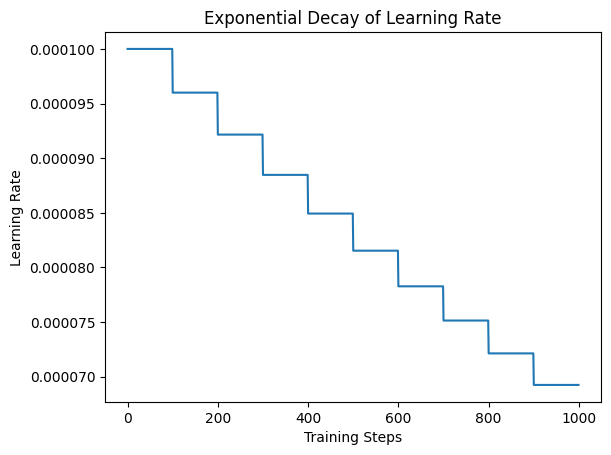

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_128            │ (None, 4, 4, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 1280)           │         5,120 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 5)              │         6,405 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,269,509 (8.66 MB)

 Trainable params: 2,232,837 (8.52 MB)

 Non-trainable params: 36,672 (143.25 KB)

Epoch 1/10
    413/Unknown 329s 669ms/step - accuracy: 0.6517 - loss: 0.9622

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


413/413 ━━━━━━━━━━━━━━━━━━━━ 345s 709ms/step - accuracy: 0.6519 - loss: 0.9617 - val_accuracy: 0.5784 - val_loss: 1.5958
Epoch 2/10
413/413 ━━━━━━━━━━━━━━━━━━━━ 321s 707ms/step - accuracy: 0.9623 - loss: 0.1310 - val_accuracy: 0.7730 - val_loss: 0.8201
Epoch 3/10
413/413 ━━━━━━━━━━━━━━━━━━━━ 323s 710ms/step - accuracy: 0.9970 - loss: 0.0237 - val_accuracy: 0.8459 - val_loss: 0.5663
Epoch 4/10
413/413 ━━━━━━━━━━━━━━━━━━━━ 321s 777ms/step - accuracy: 0.9977 - loss: 0.0120 - val_accuracy: 0.8703 - val_loss: 0.4862
Epoch 5/10
413/413 ━━━━━━━━━━━━━━━━━━━━ 322s 777ms/step - accuracy: 0.9983 - loss: 0.0075 - val_accuracy: 0.8784 - val_loss: 0.4369
Epoch 6/10
413/413 ━━━━━━━━━━━━━━━━━━━━ 286s 692ms/step - accuracy: 1.0000 - loss: 0.0043 - val_accuracy: 0.8757 - val_loss: 0.4271
Epoch 7/10
413/413 ━━━━━━━━━━━━━━━━━━━━ 322s 690ms/step - accuracy: 1.0000 - loss: 0.0028 - val_accuracy: 0.8784 - val_loss: 0.4233
Epoch 8/10
413/413 ━━━━━━━━━━━━━━━━━━━━ 289s 699ms/step - accuracy: 1.0000 - loss: 0.00

batch/accuracy,▁▂▂▃▇███████████████████████████████████
batch/batch_step,▁▁▁▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇▇▇█
batch/learning_rate,█▇▇▇▇▆▆▆▆▆▆▅▅▅▅▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁
batch/loss,██▇▇▅▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/accuracy,▁▇████████
epoch/epoch,▁▂▃▃▄▅▆▆▇█
epoch/learning_rate,█▇▅▅▄▃▂▂▁▁
epoch/loss,█▂▁▁▁▁▁▁▁▁
epoch/val_accuracy,▁▅▇███████
epoch/val_loss,█▃▂▁▁▁▁▁▁▁
batch/accuracy,1


wandb: Sweep Agent: Waiting for job.
wandb: Sweep Agent: Exiting.


In [ ]:
# Launch W&B agent
wandb.agent(sweep_id, function=train)